In [1]:
from collections import OrderedDict

import numpy as np
import trimesh
import open3d as o3d
import torch
import os
import glob


from src.polar_traversal import gather_all_paths, sample_all_paths

np.set_printoptions(precision=4, suppress=True)
torch.set_printoptions(precision=4, sci_mode=False)

In [2]:
stl_dir = "./data/face_stl/"
stls = [os.path.join(stl_dir, f) 
        for f in os.listdir(stl_dir) 
        if f.endswith(".stl")]

stls.sort()
# Problems 26, 45, 69
idx = 12
file_name = stls[idx]

file_name = './data/centered_3.stl'
print(idx, file_name)

s_no =  512
latitudes_num = s_no * 2
paths = gather_all_paths(file_name, latitudes_num)
print(len(paths))

samples_num = s_no // 2
samples = sample_all_paths(paths, samples_num)
vertices, normals = samples
vertices.shape, normals.shape

12 ./data/centered_3.stl
1024


((512, 512, 3), (512, 512, 3))

In [4]:
points = vertices.reshape(-1, 3)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)    
o3d.visualization.draw_geometries([pcd])

In [5]:
torch.cat((torch.tensor(vertices), 
             torch.tensor(normals)), dim=-1).shape

torch.Size([512, 512, 6])

In [7]:
blueprint = OrderedDict({
    'vertices': torch.tensor(vertices),
    'normals': torch.tensor(normals),
})
torch.save(blueprint, './data/blueprint.pt')

In [2]:
blueprint = torch.load('./data/blueprint.pt')
blueprint['vertices'].shape, blueprint['normals'].shape

(torch.Size([512, 512, 3]), torch.Size([512, 512, 3]))

In [3]:
from src.renderer import Renderer
from src.config import get_parser

device =  torch.device("cuda")

parser  = get_parser()
opt = parser.parse_args(args=[])
opt

renderer = Renderer(opt).to(device)
renderer

Renderer(
  (renderer): ShadingPointsRenderer(
    (rasterizer): PointsRasterizer(
      (cameras): FoVPerspectiveCameras()
    )
    (compositor): ShadingCompositor(
      (lights): PointLights()
      (materials): Materials()
      (cameras): FoVPerspectiveCameras()
    )
  )
)

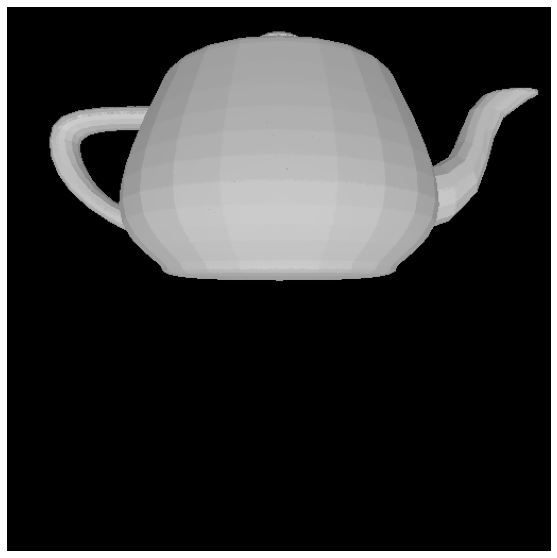

In [27]:
from pytorch3d.ops import sample_points_from_meshes


from pytorch3d.structures import (
    Pointclouds,
    Meshes,
)
from pytorch3d.io import load_obj
from pytorch3d.renderer import (
    FoVOrthographicCameras, 
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation,
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,
)

# Set the cuda device
device = torch.device("cuda:0")
torch.cuda.set_device(device)

# Load the obj and ignore the textures and materials.
verts, faces_idx, _ =  load_obj("./data/teapot.obj")
faces = faces_idx.verts_idx

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None] # (1, V, 3)
textures =  TexturesVertex(verts_features=verts_rgb.to(device))

# Create a Meshes object for the teapot. Here we have only one mesh in the batch
teapot_mesh = Meshes(
    verts=[verts.to(device)],
    faces=[faces.to(device)],
    textures=textures,
)
teapot_mesh

n_points = 1000000
vertices, normals = sample_points_from_meshes(teapot_mesh, 
    n_points, return_normals=True)

vertices =  vertices[0].to(device)
normals =  normals[0].to(device)

rgb = torch.ones((n_points, 4), device=device) - 0.3

point_cloud = Pointclouds(points=[vertices], 
                          normals=[normals],
                          features=[rgb],)


import matplotlib.pyplot as plt

images =  renderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

In [33]:
from src.util import make_faces

blueprint = torch.load('./data/blueprint.pt')
blueprint['vertices'].shape, blueprint['normals'].shape

(torch.Size([512, 512, 3]), torch.Size([512, 512, 3]))

In [34]:
w, h, _ = blueprint['vertices'].shape
faces = make_faces(w, h)
faces.shape

(522242, 3)

In [35]:
from pytorch3d.structures import Meshes

verts = blueprint['vertices'].reshape(-1, 3)
faces_idx = torch.tensor(faces)
mesh = Meshes(verts=[verts], faces=[faces_idx])
mesh

In [36]:
norms = mesh.faces_normals_list()[0]
norms.shape

torch.Size([522242, 3])

In [37]:
blueprint['normals'].reshape(-1, 3).shape

torch.Size([262144, 3])

In [38]:
verts_normals = mesh.verts_normals_list()[0]
verts_normals.shape

torch.Size([262144, 3])

In [39]:
from pytorch3d.structures import Pointclouds


verts_p = verts.to(device).float()

verts_normals_p = verts_normals.to(device).float()
#verts_rgb = torch.ones_like(verts)[None] # (1, V, 3)


rgb = torch.ones((verts_p.size(0), 4), device=device, dtype=verts_p.dtype) - 0.3

pt_cloud = Pointclouds(points=[verts_p], 
                          normals=[verts_normals_p],
                          features=[rgb],)



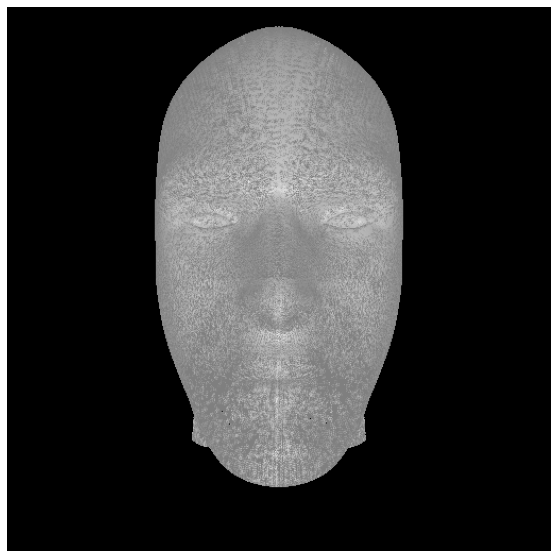

In [40]:
import matplotlib.pyplot as plt

images =  renderer(pt_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

In [29]:
vertices.dtype,normals, rgb

(torch.float32,
 tensor([[-0.7020,  0.6905, -0.1742],
         [ 0.1279, -0.1750, -0.9762],
         [ 0.7990,  0.1060,  0.5919],
         ...,
         [ 0.0090, -1.0000,  0.0038],
         [-0.0746, -0.9956, -0.0573],
         [ 0.2899, -0.6555,  0.6973]], device='cuda:0'),
 tensor([[0.7000, 0.7000, 0.7000, 0.7000],
         [0.7000, 0.7000, 0.7000, 0.7000],
         [0.7000, 0.7000, 0.7000, 0.7000],
         ...,
         [0.7000, 0.7000, 0.7000, 0.7000],
         [0.7000, 0.7000, 0.7000, 0.7000],
         [0.7000, 0.7000, 0.7000, 0.7000]], device='cuda:0'))

<bound method Meshes.verts_normals_list of <pytorch3d.structures.meshes.Meshes object at 0x7f61aafb11f0>>

In [13]:
file = stls[idx].split('/')[-1].replace('.stl', '.npz')
np.savez_compressed('./data/512/'+file, samples=samples)

In [14]:
latitudes_num = 1024
samples_num = 256

for idx, stl in enumerate(stls):
    print(idx, stl)
    file_name = stls[idx]
    print(idx, file_name)    
    paths = gather_all_paths(file_name, latitudes_num)
    samples = sample_all_paths(paths, samples_num)
    file = file_name.split('/')[-1].replace('.stl', '.npz')
    np.savez_compressed('./data/512/'+file, samples=samples)

0 ./data/stls/abe_white_inpatient.stl
0 ./data/stls/abe_white_inpatient.stl
1 ./data/stls/abigaile_ortiz_tomb_raider.stl
1 ./data/stls/abigaile_ortiz_tomb_raider.stl
2 ./data/stls/ada_wong_resident_evil.stl
2 ./data/stls/ada_wong_resident_evil.stl
3 ./data/stls/administrator_evil_within.stl
3 ./data/stls/administrator_evil_within.stl
4 ./data/stls/aidan_overkill_walking_dead.stl
4 ./data/stls/aidan_overkill_walking_dead.stl
5 ./data/stls/aloy_horizon_zero_dawn.stl
5 ./data/stls/aloy_horizon_zero_dawn.stl
6 ./data/stls/amelia_croft_tomb_raider.stl
6 ./data/stls/amelia_croft_tomb_raider.stl
7 ./data/stls/anakin_skywalker_battlefront_2.stl
7 ./data/stls/anakin_skywalker_battlefront_2.stl
8 ./data/stls/angela_civilian_detroit.stl
8 ./data/stls/angela_civilian_detroit.stl
9 ./data/stls/annie_dead_rising.stl
9 ./data/stls/annie_dead_rising.stl
10 ./data/stls/anya_gears_of_war.stl
10 ./data/stls/anya_gears_of_war.stl
11 ./data/stls/aphrodite_ascendant_one.stl
11 ./data/stls/aphrodite_ascendan

99 ./data/stls/lara_croft_tomb_raider.stl
99 ./data/stls/lara_croft_tomb_raider.stl
100 ./data/stls/laura_dawkins_two_souls.stl
100 ./data/stls/laura_dawkins_two_souls.stl
101 ./data/stls/lauren_winter_heavy_rain.stl
101 ./data/stls/lauren_winter_heavy_rain.stl
102 ./data/stls/ledolas_final_fantasy.stl
102 ./data/stls/ledolas_final_fantasy.stl
103 ./data/stls/leia_battlefront_2.stl
103 ./data/stls/leia_battlefront_2.stl
104 ./data/stls/leon_resident_evil.stl
104 ./data/stls/leon_resident_evil.stl
105 ./data/stls/lily_castellanos_evil_within.stl
105 ./data/stls/lily_castellanos_evil_within.stl
106 ./data/stls/lincoln_mafia_3.stl
106 ./data/stls/lincoln_mafia_3.stl
107 ./data/stls/luke_skywalker_battlefront_2.stl
107 ./data/stls/luke_skywalker_battlefront_2.stl
108 ./data/stls/madame_flavigny_assassins_creed.stl
108 ./data/stls/madame_flavigny_assassins_creed.stl
109 ./data/stls/madison_paige_heavy_rain.stl
109 ./data/stls/madison_paige_heavy_rain.stl
110 ./data/stls/mand_head_centered.s

In [18]:
len(paths[100])

166